```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 711902d818931f354021a809b5b19626dc97837e on branch reduced_gravity


# Boknafjorden

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler barotropic_gpu_ctx

In [5]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [6]:
source_url = "/lustre/storeB/project/fou/hi/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"
source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"

## Inspecting file structure and content

In [7]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 801, xi_rho: 1161, eta_u: 801, xi_u: 1160, eta_v: 800, xi_v: 1161)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


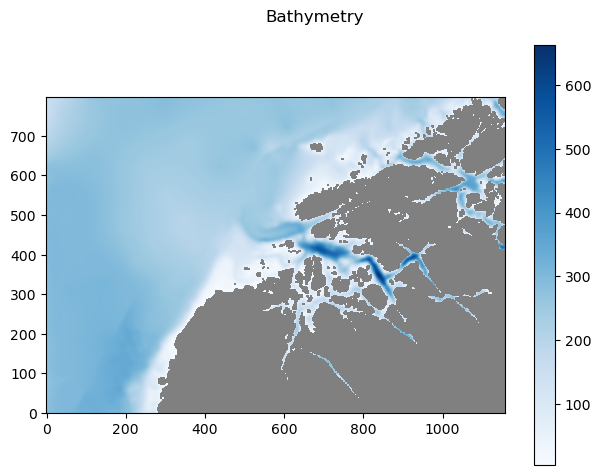

In [8]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

In [9]:
datetime.datetime.utcfromtimestamp(nc["ocean_time"][10]).strftime('%Y-%m-%d %H:%M:%S')

'2041-11-01 11:00:00'

## Generating GPUOcean Simulation from Input

In [10]:
dimY, dimX = ds.h.data.shape

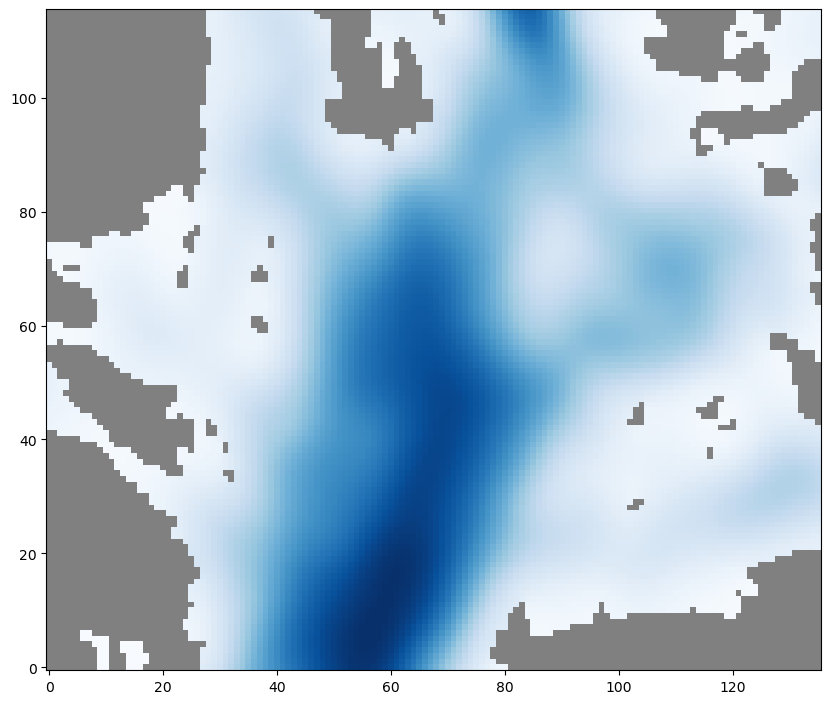

In [11]:
x0, x1, y0, y1 = 685, dimX-360, 335, dimY-330

fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")

In [12]:
nc.variables.keys()

dict_keys(['ocean_time', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'mask_rho', 'mask_u', 'mask_v', 'angle', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'aice', 'hice', 'snow_thick', 'uice', 'vice', 'zeta', 'ubar', 'vbar', 'Uwind', 'Vwind', 'swrad', 'u', 'v', 'temp', 'salt', 'AKt', 'AKs'])

In [13]:
nx = (x1-x0)-4
ny = (y1-y0)-4

NX = nx+4
NY = ny+4

dx = 160.0
dy = 160.0

Check Mixed-Layer Depth

In [14]:
t=10

In [15]:
mld = NetCDFInitialization.MLD(source_url, 1023, min_mld=1.5, max_mld=35, x0=x0, x1=x1, y0=y0, y1=y1, t=t)
backup_mld = copy.deepcopy(mld)

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  


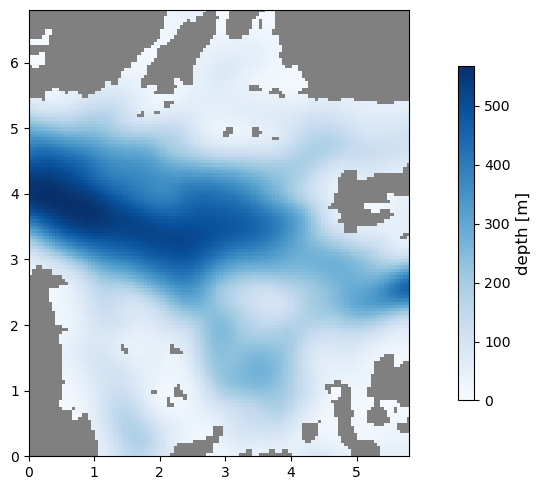

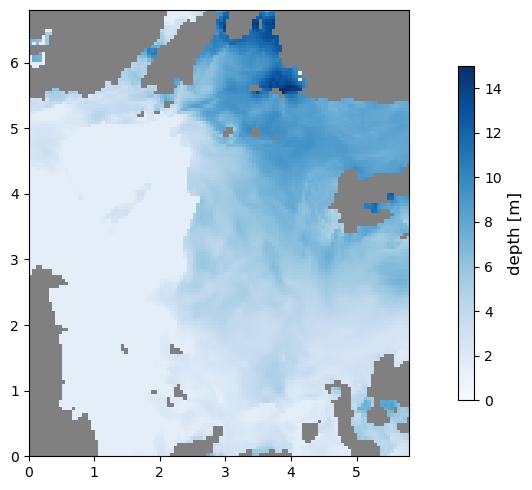

In [16]:
cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)

domain_extent = [0, mld.shape[1]*50/1000, 0, mld.shape[0]*50/1000]

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(1-nc["mask_rho"][y0:y1,x0:x1])), 
                   vmin=0,
                   cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.75)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    # plt.savefig("figs/Oslofjord-bathymetry.pdf", dpi=200)


    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(mld, 
                    vmin=0, vmax=15,
                    cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.75)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()
    # plt.savefig("figs/Oslofjord-mld.pdf", dpi=200)


/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


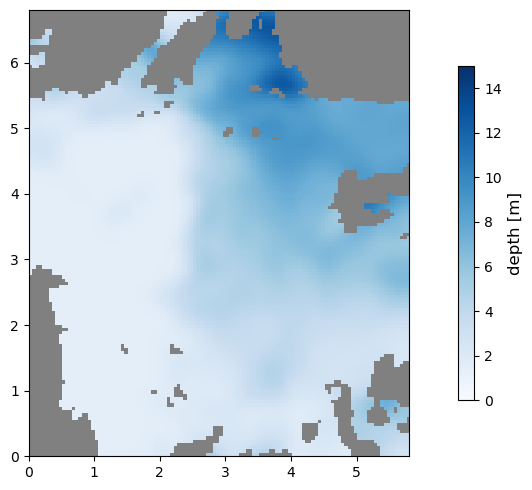

In [17]:
from scipy.ndimage import gaussian_filter

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))
    smoothed_mld = gaussian_filter(mld.filled(0.0), sigma=2.5, mode="nearest")
    normaliser = gaussian_filter(np.ones_like(mld).filled(0.0), sigma=2.5, mode="nearest")   
    smooth_mld = np.ma.array(smoothed_mld/normaliser, mask=mld.mask)
    im = ax.imshow(smooth_mld, 
                    vmin=0, vmax=15,
                    cmap=cmap, extent=domain_extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.75)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()

Check densities

In [18]:
y_cut = 60

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


2041-11-01 11:00:00


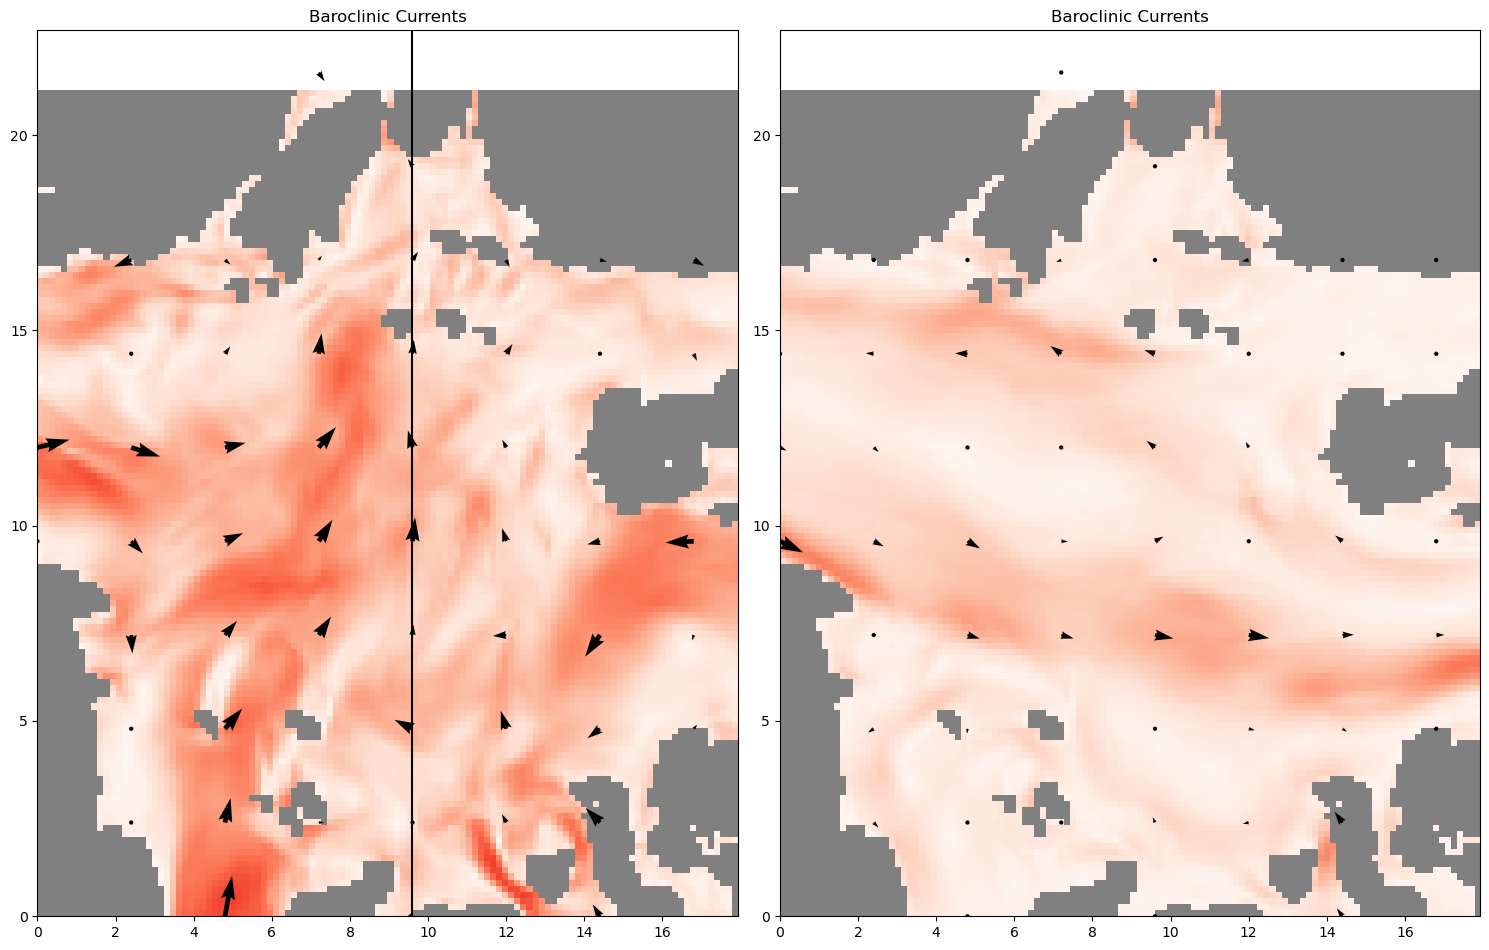

In [19]:
H_m = nc["h"][y0:y1,x0:x1]

u = 0.5*(nc["u"][t,:,y0:y1,x0:x1]+nc["u"][t,:,y0:y1,x0+1:x1+1])
v = 0.5*(nc["v"][t,:,y0:y1,x0:x1]+nc["v"][t,:,y0+1:y1+1,x0:x1])

integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)
hu = np.ma.array(np.sum(integrator * u, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])
hv = np.ma.array(np.sum(integrator * v, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])

u = hu/mld
v = hv/mld
velocity = np.sqrt(u*u + v*v)

domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]

frequency_x = 15
frequency_y = 15
x = np.arange(0, velocity.shape[1], frequency_x)*dx/1000
y = np.arange(0, velocity.shape[0], frequency_y)*dy/1000
qu = u[::frequency_y, ::frequency_x]
qv = v[::frequency_y, ::frequency_x]

# ---------------------------

bt_u = 0.5*(nc["ubar"][t,y0:y1,x0:x1]+nc["ubar"][t,y0:y1,x0+1:x1+1])
bt_v = 0.5*(nc["vbar"][t,y0:y1,x0:x1]+nc["vbar"][t,y0+1:y1+1,x0:x1])

bt_velocity = np.sqrt(bt_u*bt_u + bt_v*bt_v)

bt_qu = bt_u[::frequency_y, ::frequency_x]
bt_qv = bt_v[::frequency_y, ::frequency_x]


# ----------------------------

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, axs = plt.subplots(1,2,figsize=(15,10))

    # ax.tick_params(colors='black')
    axs[0].xaxis.label.set_color('black')

    velo_cmap = plt.cm.Reds
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = axs[0].imshow(velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    axs[0].quiver(x,y,qu,qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    axs[0].axvline(x=y_cut*dx/1000, c="black")
    
    axs[0].set_title("Baroclinic Currents")
    
    # -------------------------------------
    
    im = axs[1].imshow(bt_velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    axs[1].quiver(x,y,bt_qu,bt_qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=1)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    axs[1].set_title("Baroclinic Currents")


    plt.tight_layout()

    # plt.savefig("figs/PotDensLine.pdf", dpi=200)

print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))


/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))


2041-11-01 11:00:00


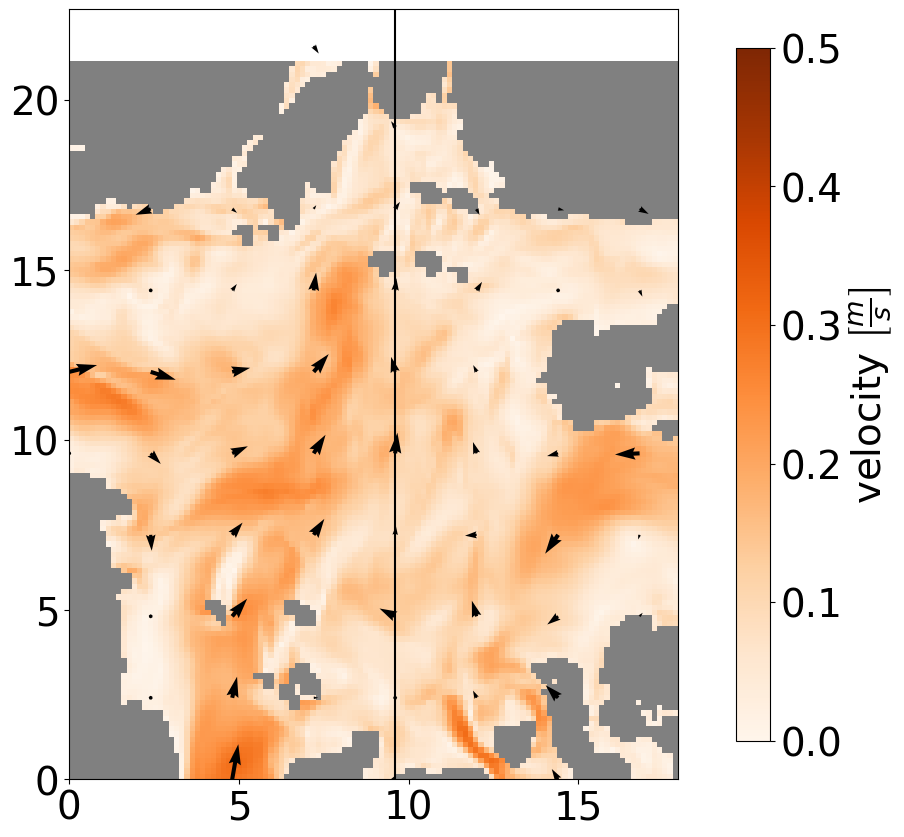

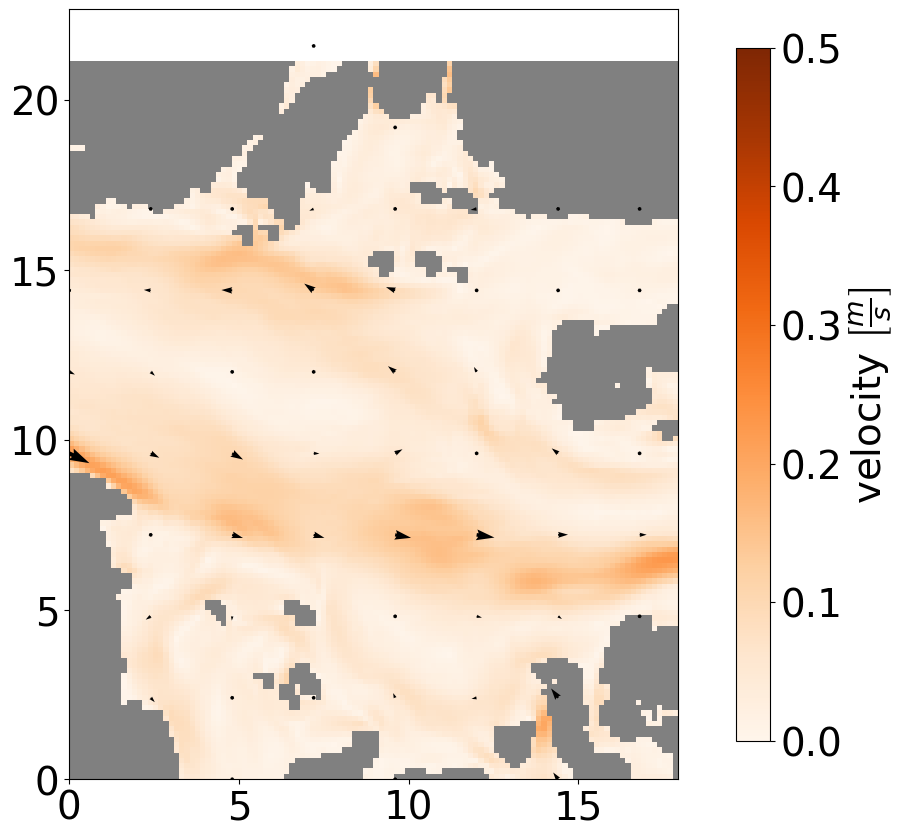

In [20]:
H_m = nc["h"][y0:y1,x0:x1]

u = 0.5*(nc["u"][t,:,y0:y1,x0:x1]+nc["u"][t,:,y0:y1,x0+1:x1+1])
v = 0.5*(nc["v"][t,:,y0:y1,x0:x1]+nc["v"][t,:,y0+1:y1+1,x0:x1])

integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)
hu = np.ma.array(np.sum(integrator * u, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])
hv = np.ma.array(np.sum(integrator * v, axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])

u = hu/mld
v = hv/mld
velocity = np.sqrt(u*u + v*v)

domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]

frequency_x = 15
frequency_y = 15
x = np.arange(0, velocity.shape[1], frequency_x)*dx/1000
y = np.arange(0, velocity.shape[0], frequency_y)*dy/1000
qu = u[::frequency_y, ::frequency_x]
qv = v[::frequency_y, ::frequency_x]

# ---------------------------

bt_u = 0.5*(nc["ubar"][t,y0:y1,x0:x1]+nc["ubar"][t,y0:y1,x0+1:x1+1])
bt_v = 0.5*(nc["vbar"][t,y0:y1,x0:x1]+nc["vbar"][t,y0+1:y1+1,x0:x1])

bt_velocity = np.sqrt(bt_u*bt_u + bt_v*bt_v)

bt_qu = bt_u[::frequency_y, ::frequency_x]
bt_qv = bt_v[::frequency_y, ::frequency_x]


# ----------------------------

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.xaxis.label.set_color('black')

    velo_cmap = plt.cm.Oranges
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    ax.quiver(x,y,qu,qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=0.9)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=28)
    cb.ax.tick_params(labelsize=28)
    
    ax.axvline(x=y_cut*dx/1000, c="black")

    plt.savefig("BoknafjordenBaroclinicInit.pdf", bbox_inches="tight")
    
    # -------------------------------------
    

    fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.xaxis.label.set_color('black')

    im = ax.imshow(bt_velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    ax.quiver(x,y,bt_qu,bt_qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=0.9)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=28)
    cb.ax.tick_params(labelsize=28)

    plt.savefig("BoknafjordenBarotropicInit.pdf", bbox_inches="tight")

print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))


In [21]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

s_nc = Dataset(source_url)
s_hs   = s_nc["h"][y0:y1,x0:x1]
s_rhos = s_nc["Cs_r"][:]

depth_show_meters = 50 # upper layer thickness for plotting in meters

depth_show_resolution = 4 # discretisation levels per meter

s_pot_densities_show = np.ma.array(np.zeros((s_pot_densities.shape[1],depth_show_meters*depth_show_resolution)))
s_pot_densities_show[:,0] =  s_pot_densities[-1][:,y_cut]
for depth_level in range(1,depth_show_resolution*depth_show_meters):
    depth = depth_level/depth_show_resolution

    integrator_low = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(depth*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
    dens_low = np.sum(integrator_low * s_pot_densities, axis=0)
    if depth_level == 1:
        dens_up = 0.0
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        mask_next_level = copy.copy(s_pot_densities_show[:,depth_level]<1000)
    else:
        integrator_up = NetCDFInitialization.MLD_integrator(source_url, np.ma.array((depth-1/depth_show_resolution)*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
        dens_up  = np.sum(integrator_up * s_pot_densities, axis=0)
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        s_pot_densities_show[:,depth_level].mask = copy.copy(mask_next_level)
        if depth > 5:
            mask_next_level = np.all((integrator_low[1:,:,y_cut] == integrator_up[1:,:,y_cut]), axis=0)

In [22]:
import matplotlib.lines as mlines

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd_r"))
  after removing the cwd from sys.path.


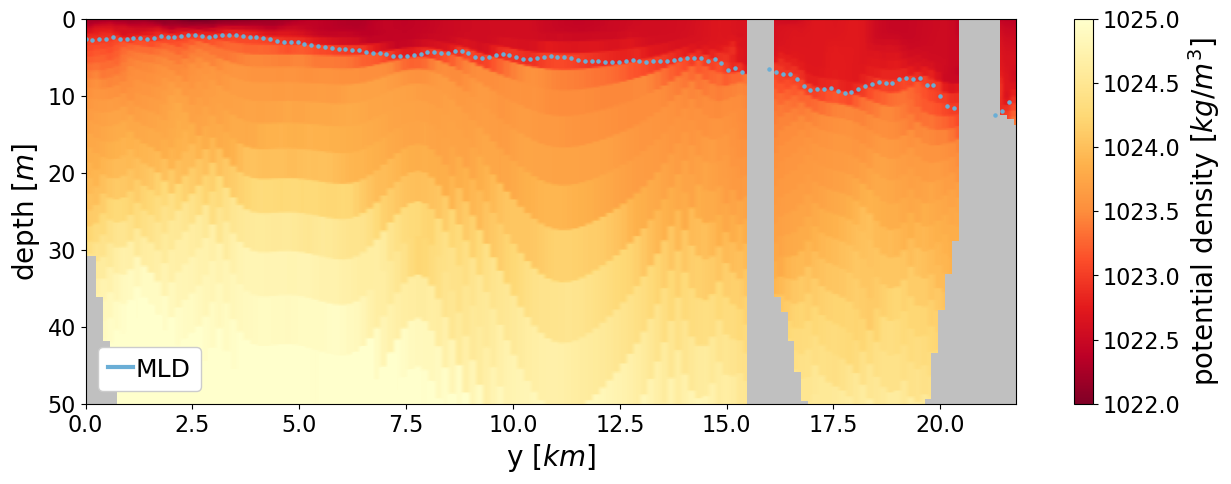

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap_dens = plt.cm.YlOrRd_r
cmap_dens.set_bad(alpha=0.25)

extent = [0, s_pot_densities_show.shape[0]*160/1000, depth_show_meters, 0]

im = ax.imshow(s_pot_densities_show.T, 
                origin="upper", cmap=cmap_dens, 
                aspect='auto', extent=extent, 
                vmin=1022, vmax=1025)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("depth [$m$]", fontsize=20)
ax.set_xlabel("y [$km$]", fontsize=20)

cb = plt.colorbar(im, pad=0.05)
cb.set_label(label="potential density [$kg/m^3$]", size=20)
cb.ax.tick_params(labelsize=16)

ax.scatter(np.arange(s_pot_densities.shape[1])*160/1000, mld[:,y_cut], s=5, color=plt.cm.Blues(0.5))

legend_handle = mlines.Line2D([], [], c=plt.cm.Blues(0.5), lw=3, label="MLD")
plt.legend(handles=[legend_handle], handlelength=1, loc=3, 
        handletextpad=0.1, 
        facecolor="white", framealpha=1,
        labelcolor="black", fontsize=18)

plt.savefig("BoknafjordenMLD.pdf", bbox_inches="tight")

Note that the stratification is less pronounced than in the Oslofjord, but we still get a usable and shallow MLD

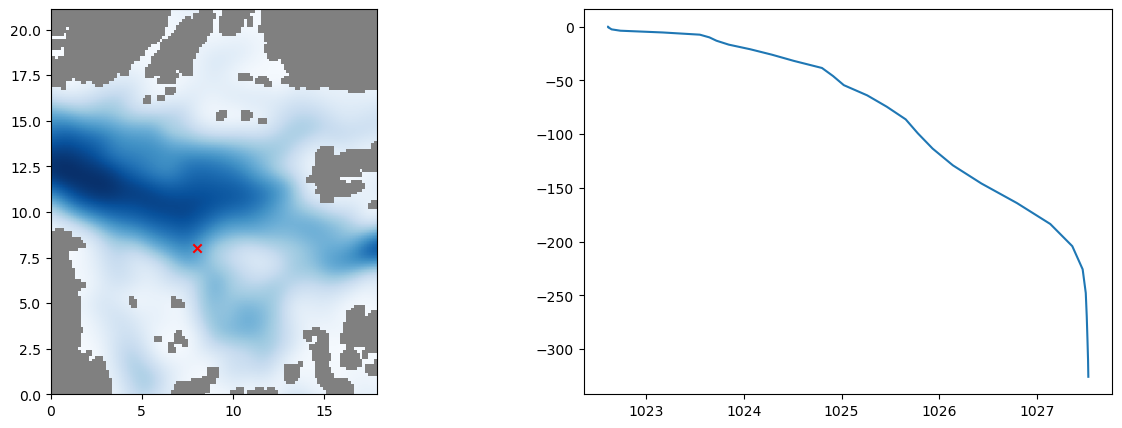

In [24]:
x, y = 50,50
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(1-nc["mask_rho"][y0:y1,x0:x1])), cmap="Blues", extent=domain_extent)
axs[0].scatter(x*dx/1000,y*dx/1000, marker="x", color="red")

axs[1].plot(s_pot_densities[:,y,x], nc["Cs_r"]*(nc["h"][y0:y1,x0:x1][y,x]))

## GPU Ocean Inputs

In [25]:
t_start = t
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

In [26]:
barotropic_data_args, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1023, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

In [27]:
baroclinic_data_args["eta0"] = smooth_mld

In [28]:
baroclinic_data_args["boundary_conditions"].spongeCells = {'north': 2, 'south': 2, 'east': 2, 'west': 2}

### Drifters

In [29]:
windage = 0.0

Barotropic drift

In [30]:
from gpuocean.SWEsimulators import CDKLM16

In [31]:
barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [32]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [33]:
initx = np.array([ 2500,  6000, 11000,  7500])
inity = np.array([10000,  7500,  7000, 12000])

num_drifters = len(initx)

In [34]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': barotropic_sim.nx, 'ny': barotropic_sim.ny,
                'domain_size_x': barotropic_sim.nx*barotropic_sim.dx,
                'domain_size_y': barotropic_sim.ny*barotropic_sim.dy,
                'land_mask': barotropic_sim.getLandMask()
                }

bt_trajectories = Observation.Observation(**observation_args)

In [35]:
bt_drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = bt_trajectories.domain_size_x,
                                                    domain_size_y = bt_trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream,
                                                    wind = barotropic_data_args["wind"],
                                                    wind_drift_factor=windage
                                                    )

drifter_pos_init = np.array([initx, inity]).T
bt_drifters.setDrifterPositions(drifter_pos_init)



In [36]:
barotropic_sim.attachDrifters(bt_drifters)
bt_trajectories.add_observation_from_sim(barotropic_sim)

In [37]:
while barotropic_sim.t < T:
    barotropic_sim.step(300)
    bt_trajectories.add_observation_from_sim(barotropic_sim)

In [38]:
sys.path.append(os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir)))
from utils import animation_utils

In [39]:
# animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="Barotropic", uv_min=-25, uv_max=25, h_min=-1, h_max=1)

Baroclinic drift

In [40]:
baroclinic_data_args["wind_stress_factor"] = 0.5
baroclinic_data_args["r"] = 0.0015

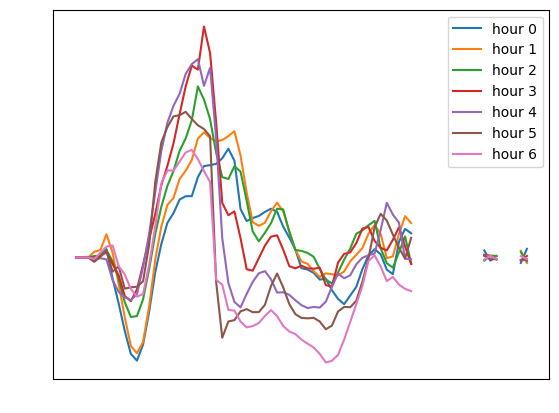

In [41]:
for hour in range(7):
    plt.plot(baroclinic_data_args["boundary_conditions_data"].west.hu[hour]/baroclinic_data_args["boundary_conditions_data"].west.h[hour], label="hour "+str(hour))
plt.legend(labelcolor="black")

In [42]:
baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [43]:
bc_trajectories = Observation.Observation(**observation_args)

In [44]:
bc_drifters = GPUDrifterCollection.GPUDrifterCollection(baroclinic_gpu_ctx, num_drifters,
                                                    boundaryConditions = baroclinic_sim.boundary_conditions,
                                                    domain_size_x = bc_trajectories.domain_size_x,
                                                    domain_size_y = bc_trajectories.domain_size_y,
                                                    gpu_stream = baroclinic_sim.gpu_stream,
                                                    wind = baroclinic_data_args["wind"],
                                                    wind_drift_factor=windage
                                                    )

bc_drifters.setDrifterPositions(drifter_pos_init)

In [45]:
baroclinic_sim.attachDrifters(bc_drifters)
bc_trajectories.add_observation_from_sim(baroclinic_sim)

In [46]:
while baroclinic_sim.t < T:
    baroclinic_sim.step(300)
    bc_trajectories.add_observation_from_sim(baroclinic_sim)

In [47]:
# animation_utils.ncAnimation(baroclinic_sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="Baroclinic")

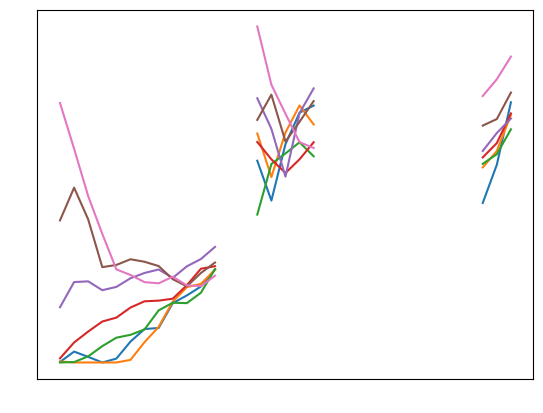

In [48]:
for hour in range(7):
    plt.plot(baroclinic_data_args["boundary_conditions_data"].north.h[hour])

Combined sim

In [49]:
from gpuocean.SWEsimulators import CombinedCDKLM16

In [50]:
from importlib import reload
reload(CombinedCDKLM16)

<module 'gpuocean.SWEsimulators.CombinedCDKLM16' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CombinedCDKLM16.py'>

In [51]:
barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0)
baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args), dt=0.0)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Boknafjord/netcdf_2023_11_16/CDKLM16_2023_11_16-11_59_50.nc ...


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Boknafjord/netcdf_2023_11_16/CDKLM16_2023_11_16-11_59_57.nc ...


In [52]:
combined_sim = CombinedCDKLM16.CombinedCDKLM16(barotropic_sim=barotropic_sim, baroclinic_sim=baroclinic_sim)

In [53]:
combi_trajectories = Observation.Observation(**observation_args)

In [54]:
combi_drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = combined_sim.boundary_conditions,
                                                    domain_size_x = combi_trajectories.domain_size_x,
                                                    domain_size_y = combi_trajectories.domain_size_y,
                                                    gpu_stream = combined_sim.gpu_stream,
                                                    wind = barotropic_data_args["wind"],
                                                    wind_drift_factor=windage/2
                                                    )


In [55]:
combi_drifters.setDrifterPositions(drifter_pos_init)

In [56]:
combined_sim.attachDrifters(combi_drifters)
combi_trajectories.add_observation_from_sim(combined_sim)

In [57]:
combined_sim.combinedStep(T, trajectory_dt=360, trajectories=combi_trajectories)

(21600.0, 21600.0)

### Plots

In [91]:
def plot_trajectory(trajectories0, trajectories1, trajectories2, trajectories3=None, zoom=[0, None, 0, None]):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(7.5,7.5))
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.set_xticks([0,5,10,15,20])
        ax.set_yticks([0,5,10,15,20])

        zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

        if zoom_x1 is None:
            dom_x1 = nx
        else:
            dom_x1 = zoom_x1
        if zoom_y1 is None:
            dom_y1 = ny
        else:
            dom_y1 = zoom_y1
        domain_extent = [zoom_x0*dx/1000, dom_x1*dx/1000, zoom_y0*dy/1000, dom_y1*dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)
        
        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1])), 
                  interpolation="none", origin='lower', cmap=bg_cmap, extent=domain_extent)

        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(0, 25, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(40, 70, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e
        

        for d in range(len(initx)):
            path = trajectories0.get_drifter_path(d, 0, T, in_km = True)[0]
            start_pos = path[0,:]
            circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                    0.1, color = 'black', fill=True, zorder=10)
            ax.add_patch(circ_start)

            colors = ["C2", "C8", "C3", "C1"]            
            trajectory_list = [trajectories0, trajectories1, trajectories2]
            if trajectories3 is not None:
                trajectory_list.append(trajectories3)
            for p_idx, path in enumerate([t.get_drifter_path(d, 0, T, in_km = True)[0] for t in trajectory_list]):
                ax.plot(path[:,0], path[:,1], color=colors[p_idx], ls="-", zorder=5, alpha=1.0, lw=2.0)
                end_pos = path[-1,:]
                ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=50, linewidths=1, alpha=1.0, zorder=6)

        plt.tight_layout()

        legend_handles = [ mlines.Line2D([], [], c="C2", lw=6, label="Barotropic"),
                            mlines.Line2D([], [], c="C8", lw=6, label="Baroclinic"),
                            mlines.Line2D([], [], c="C3", lw=6, label="Combined")]
        if trajectories3 is not None:
            legend_handles.append( mlines.Line2D([], [], c="C3", lw=6, label="OpenDrift") )
        plt.legend(handles=legend_handles, handlelength=1,
        facecolor="white", framealpha=1,
        labelcolor="black", fontsize=24)

        ax.annotate("B",[initx[1]/1000-0.8, inity[1]/1000-1.8], fontsize=42 )
        ax.annotate("C",[initx[2]/1000-0.8, inity[2]/1000-1.8], fontsize=42 )
        ax.annotate("A",[initx[0]/1000-1.6, inity[0]/1000-0.6], fontsize=42 )
        ax.annotate("D",[initx[3]/1000+0.6, inity[3]/1000-0.6], fontsize=42 )

        os.makedirs("boknafjorden_figs", exist_ok=True)
        plt.savefig("boknafjorden_figs/boknafjordenDrifts.pdf", bbox_inches="tight")

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))


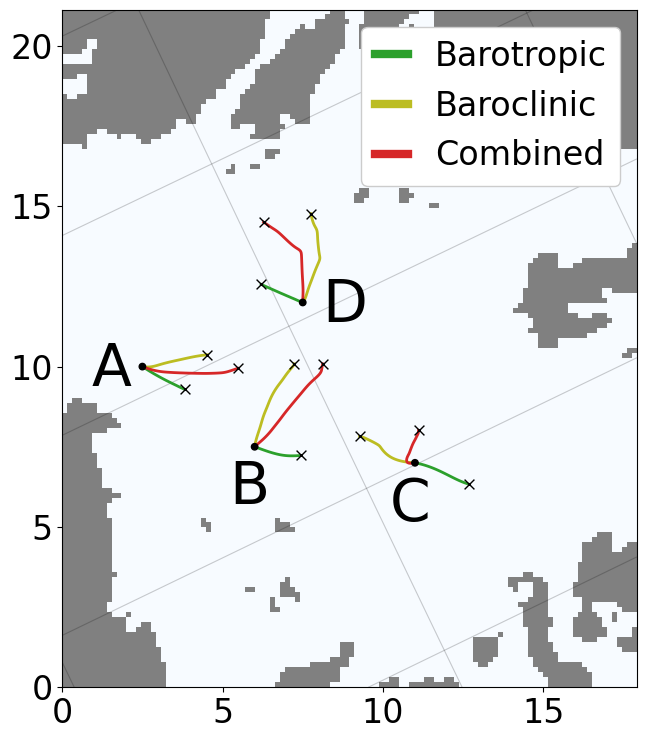

In [92]:
plot_trajectory(bt_trajectories, bc_trajectories, combi_trajectories)

## OpenDrift

In [60]:
from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
from opendrift.models.oceandrift import OceanDrift
from datetime import timedelta

import xarray as xr

Exception caught: Resetting to CUDA context baroclinic_gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_285042/1159432738.py", line 1, in <module>
    from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
ModuleNotFoundError: No module named 'opendrift'


ModuleNotFoundError: No module named 'opendrift'

In [ ]:
reader_boknafjorden = reader_ROMS_native.Reader(source_url)
reader_boknafjorden.start_time

In [ ]:
# Checking how to map (x,y) to/from (lon, lat)

#eta_rho: 801 xi_rho: 1161
lon0 = ds.lon_rho.isel(eta_rho=0, xi_rho=0).data, 
lat0 = ds.lat_rho.isel(eta_rho=0, xi_rho=0).data
print("lonlat(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lon0, lat0))

lonend = ds.lon_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
latend = ds.lat_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
print("lonlat(-1, -1): ", (lonend, latend))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lonend, latend))


lon0u = ds.lon_u.isel(eta_u=0, xi_u=0).data, 
lat0u = ds.lat_u.isel(eta_u=0, xi_u=0).data
print("lonlatu(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lon0, lat0))

Based on the dimensions of eta_* and xi_*, it seems that eta_rho and xi_rho is from boundary to boundary. 

In [ ]:
# Translate initx, inity to initlon, initlat
init_local_index_x = np.array(initx)/160
init_local_index_y = np.array(inity)/160

init_global_index_x = init_local_index_x + x0
init_global_index_y = init_local_index_y + y0

print(init_local_index_x)
print(init_global_index_x)

init_lon, init_lat = reader_boknafjorden.xy2lonlat(init_global_index_x, init_global_index_y)
print("init_lon: ", init_lon)
print("init_lat: ", init_lat)

In [ ]:
o = OceanDrift(loglevel=20)

#o.add_reader([reader_barents, reader_wind])
o.add_reader(reader_boknafjorden)


In [ ]:
o.seed_elements(lat=init_lat, lon=init_lon, time=reader_boknafjorden.start_time+ timedelta(hours=10), 
                wind_drift_factor=np.zeros_like(init_lat))


In [ ]:
o.run(duration = timedelta(hours=6), time_step=600, time_step_output=600)


In [ ]:
o_trajectories = Observation.Observation(domain_size_x=nx*dx, domain_size_y=ny*dy, nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [ ]:
t = o.get_time_array()[1]
for i in range(len(t)):
    t[i] = t[i].total_seconds()
t = np.array(t)

In [ ]:
lon, lat = o.get_lonlats()
x,y = reader_boknafjorden.lonlat2xy(lon,lat)

In [ ]:
X = (x-x0)*160
Y = (y-y0)*160

In [ ]:
o_trajectories = Observation.Observation(domain_size_x=dx*nx, domain_size_y=ny*dy,
                        nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [ ]:
o_trajectories.add_observations_from_arrays(t, X, Y)

In [ ]:
plot_trajectory(bt_trajectories, bc_trajectories, combi_trajectories, o_trajectories)